<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Bahar Oveis Gharan
### Student Number : 98106242

___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [ ]:
# run this cell to download and prepare data

from data_utils import download_data, prepare_data
download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


In [ ]:
df.groupby('class_name').max().head()

,name,class_label
class_name,,
Ellipticals,PGC0072272,0
Irregulars,PGC0073177,3
Lenticulars,PGC0072803,1
Spirals,PGC0072930,2


##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################


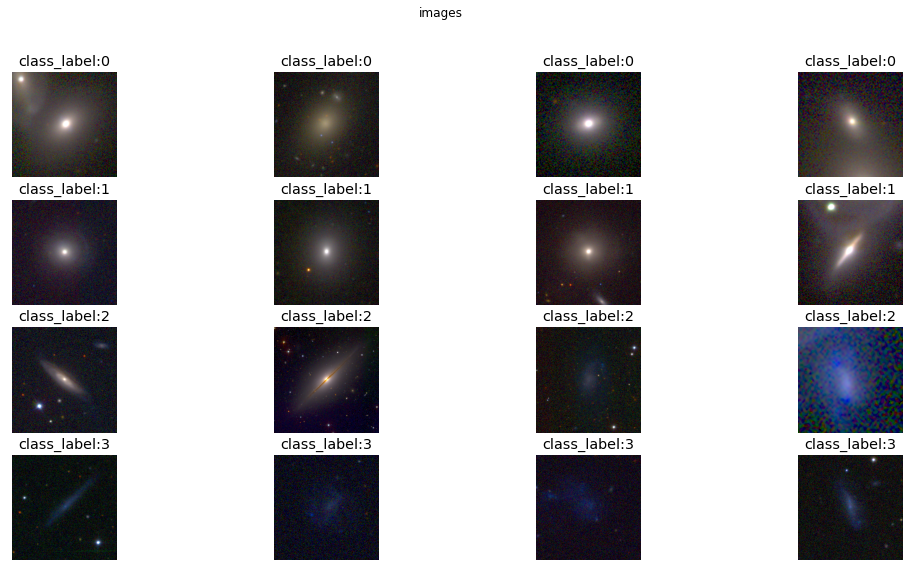

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4 , ncols=4, figsize=(18, 9))
ax = ax.flatten()
for i in range(4):
   new_df = df[df.class_label==i].head(4)
   name_list = list(new_df["name"])
   for j in range(4):
      s = name_list[j]
      address = '/content/efigi-1.6/png/'+s+'.png'
      img = plt.imread(address)
      ax[i*4+j].imshow(img)
      ax[i*4+j].set_xticks([])
      ax[i*4+j].set_yticks([])
      ax[i*4+j].set_title("class_label:{}".format(i))

plt.suptitle("images")

plt.savefig('samples.png', bbox_inches='tight')
plt.show()

# Define Dataset (20 Points)

In [ ]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################
import cv2 as cv

class GalaxyDataSetTransformer(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform
    def __len__(self, ):
        return len(self.base_dataset)
    def __getitem__(self, index):
        target = self.base_dataset.iloc[index][2]
        s = self.base_dataset.iloc[index][0]
        # read the png image
        img = cv.imread('/content/efigi-1.6/png/'+ s +'.png')
        img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
        return self.transform(img), target


In [ ]:
from sklearn.model_selection import train_test_split
test_ratio = 0.3
valid_ratio = 0.2

train_Val_df , test_dataset = train_test_split(df, test_size=test_ratio)
train_dataset , valid_dataset=train_test_split(train_Val_df, test_size=valid_ratio)

'\ntrain_valid_dataset, test_dataset = torch.utils.data.dataset.random_split(df, [nb_train_valid, nb_test])\n\nnb_valid = int(valid_ratio * len(df))\nnb_train = nb_train_valid - nb_valid \n\ntrain_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])\n'

In [ ]:
train_dataset = GalaxyDataSetTransformer(train_dataset, transforms.ToTensor())
valid_dataset = GalaxyDataSetTransformer(valid_dataset, transforms.ToTensor())
test_dataset  = GalaxyDataSetTransformer(test_dataset , transforms.ToTensor())


In [ ]:
num_threads = 5     
batch_size  = 100   



train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,                
                                          num_workers=num_threads)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_threads)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_threads)


print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 2496 images, in 25 batches
The validation set contains 624 images, in 7 batches
The test set contains 1338 images, in 14 batches


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Define Model (20 Points)

In [ ]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

def linear_relu(dim_in, dim_out):
    return [nn.Linear(dim_in, dim_out),nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ClassifierModel, self).__init__()
        self.classifier =  nn.Sequential(
            *linear_relu(input_size, 250),
            *linear_relu(250, 250),
            nn.Linear(250, num_classes)
        )
        
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        y = self.classifier(x)
        return y
        

# Train Model (30 Points)

In [ ]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

def train(model, loader, f_loss, optimizer, device):
    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = f_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




In [ ]:
def test(model, loader, f_loss, device):
    
    with torch.no_grad():
        model.eval()
        N = 0
        tot_loss, correct = 0.0, 0.0
        for i, (inputs, targets) in enumerate(loader):
            # We got a minibatch from the loader within inputs and targets
            # With a mini batch size of 128, we have the following shapes
            #    inputs is of shape (128, 1, 28, 28)
            #    targets is of shape (128)

            # We need to copy the data on the GPU if we use one
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            N += inputs.shape[0]
            tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
            predicted_targets = outputs.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return tot_loss/N, correct/N

In [ ]:

f_loss = torch.nn.CrossEntropyLoss()
model=ClassifierModel(3*255*255, 4)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

epochs = 30
FC1 = []
FC2 = []
FC3 = []
FC4 = []
for t in range(epochs):
    print("Epoch {}".format(t))
    train(model, train_loader, f_loss, optimizer, device)
    val_loss, val_acc = test(model, valid_loader, f_loss, device)
    train_loss, train_acc = test(model, train_loader, f_loss, device)
    FC1.append(val_loss)
    FC2.append(val_acc)
    FC3.append(train_loss)
    FC4.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))


Epoch 0
 Training : Loss : 1.3910, Acc : 0.7412
 Validation : Loss : 1.3794, Acc : 0.7372
Epoch 1
 Training : Loss : 0.8684, Acc : 0.7412
 Validation : Loss : 0.9080, Acc : 0.7372
Epoch 2
 Training : Loss : 0.6850, Acc : 0.7905
 Validation : Loss : 0.7556, Acc : 0.7372
Epoch 3
 Training : Loss : 0.5467, Acc : 0.7941
 Validation : Loss : 0.7272, Acc : 0.7404
Epoch 4
 Training : Loss : 0.3915, Acc : 0.8702
 Validation : Loss : 0.6186, Acc : 0.7564
Epoch 5
 Training : Loss : 0.2902, Acc : 0.9058
 Validation : Loss : 0.6591, Acc : 0.7468
Epoch 6
 Training : Loss : 0.2202, Acc : 0.9315
 Validation : Loss : 0.7014, Acc : 0.7436
Epoch 7
 Training : Loss : 0.2159, Acc : 0.9471
 Validation : Loss : 0.7103, Acc : 0.7420
Epoch 8
 Training : Loss : 0.1701, Acc : 0.9459
 Validation : Loss : 0.8325, Acc : 0.7628
Epoch 9
 Training : Loss : 0.0938, Acc : 0.9764
 Validation : Loss : 0.7146, Acc : 0.7548
Epoch 10
 Training : Loss : 0.0540, Acc : 0.9936
 Validation : Loss : 0.7989, Acc : 0.7564
Epoch 11


##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################



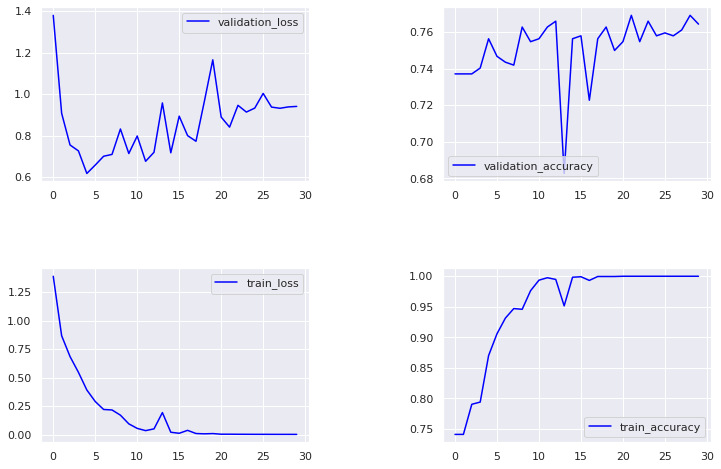

In [ ]:
import seaborn as sns
sns.set()
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)


sns.lineplot(data=FC1, ax=axes[0, 0], color='blue', label="validation_loss");
sns.lineplot(data=FC2, ax=axes[0, 1], color='blue', label="validation_accuracy");
sns.lineplot(data=FC3, ax=axes[1, 0], color='blue', label="train_loss");
sns.lineplot(data=FC4, ax=axes[1, 1], color='blue', label="train_accuracy");


# Test Model (20)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


test loss:0.8821055775087867  test_acc:0.7720478325859492 f1_score:0.44280461600458465


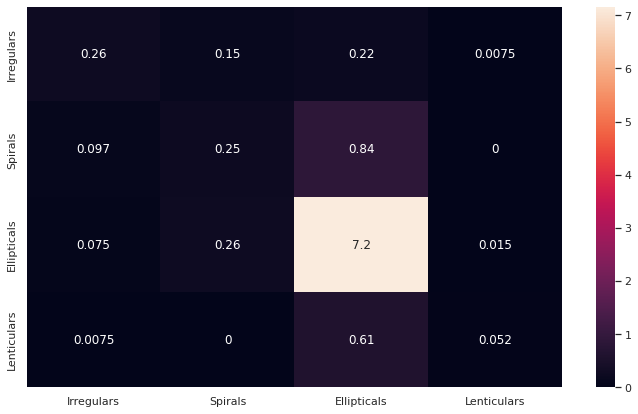

In [ ]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

test_loss, test_acc = test(model, test_loader, f_loss, device)


y_pred = []
y_true = []
with torch.no_grad():
    model.eval()
    N = 0
    tot_loss, correct = 0.0, 0.0
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        N += inputs.shape[0]
        tot_loss += inputs.shape[0] * f_loss(outputs, targets).item()
        predicted_targets = outputs.argmax(dim=1)
        y_pred.extend(predicted_targets)
        y_true.extend(targets)
        correct += (predicted_targets == targets).sum().item()
    test_loss, test_acc = tot_loss/N, correct/N


classes = ("Irregulars", "Spirals", "Ellipticals", "Lenticulars")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

def f1_score(confusion_matrix):
    rows_sum=np.sum(confusion_matrix,axis=1)
    cols_sum=np.sum(confusion_matrix,axis=0)
    prec_classes=confusion_matrix.diagonal()/rows_sum
    recal_classes=confusion_matrix.diagonal()/cols_sum
    f1_score =np.mean(2*((prec_classes*recal_classes)/(prec_classes+recal_classes)))
    return f1_score

print("test loss:{}  test_acc:{} f1_score:{}".format( test_loss, test_acc,f1_score(cf_matrix)))

